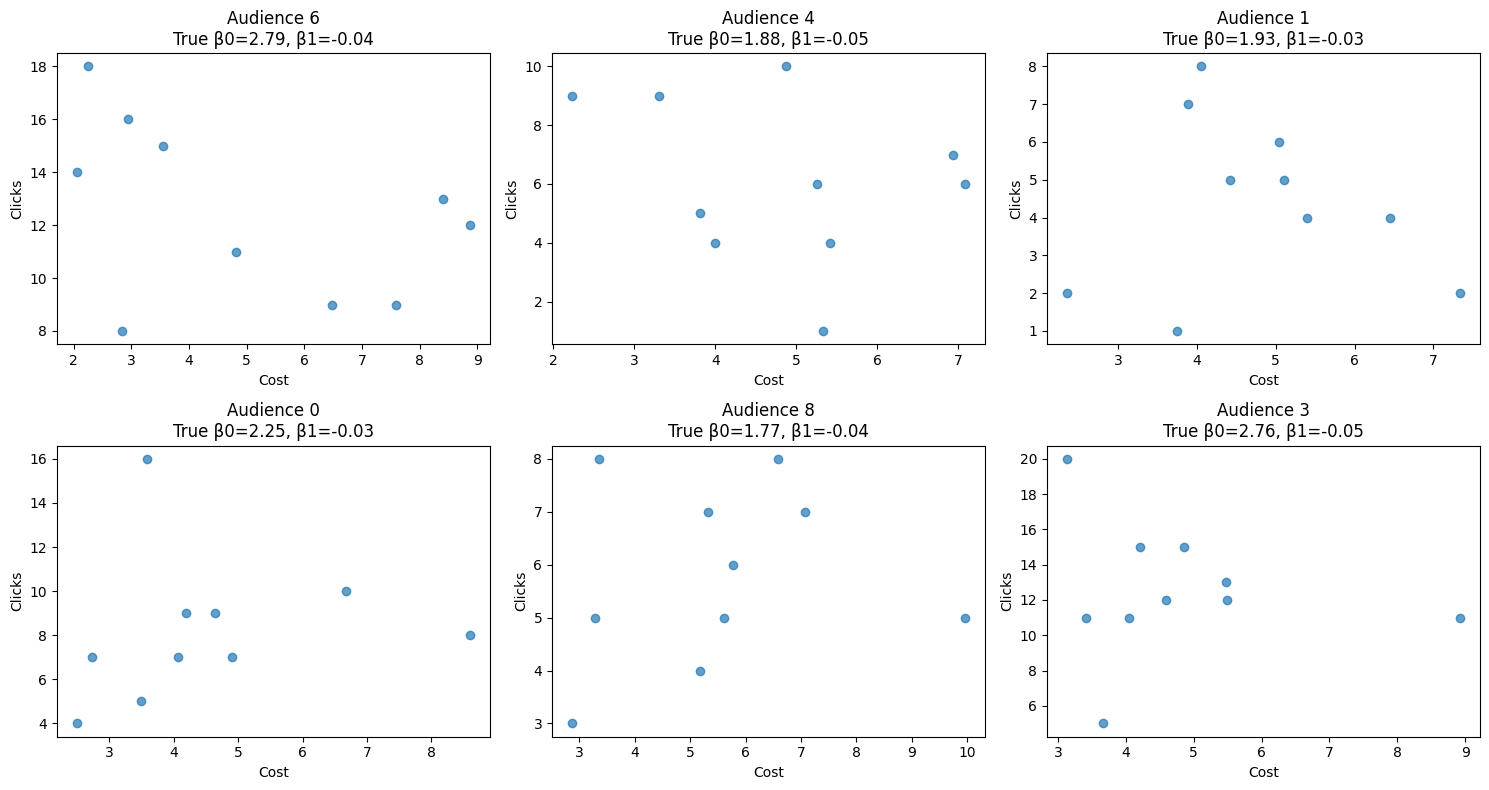

In [4]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Set seed
np.random.seed(42)

# Simulation parameters
N_AUDIENCES = 10  # Number of unique audience members
OBS_PER_AUDIENCE = 10  # Observations per audience member

# True hyperparameters
hyper_mu_intercept = 2.0    # Population-level intercept
hyper_sigma_intercept = 0.5 # Between-audience intercept variability
hyper_mu_slope = -0.03      # Population-level cost slope 
hyper_sigma_slope = 0.01    # Between-audience slope variability

# Simulate audience-specific parameters
audience_ids = np.repeat(np.arange(N_AUDIENCES), OBS_PER_AUDIENCE)
true_intercepts = np.random.normal(hyper_mu_intercept, hyper_sigma_intercept, N_AUDIENCES)
true_slopes = np.random.normal(hyper_mu_slope, hyper_sigma_slope, N_AUDIENCES)

# Simulate cost and clicks
cost = np.random.gamma(shape=5, scale=1, size=N_AUDIENCES*OBS_PER_AUDIENCE)
eta = true_intercepts[audience_ids] + true_slopes[audience_ids] * cost
clicks = np.random.poisson(lam=np.exp(eta))

# Create DataFrame
data = pd.DataFrame({
    "audience_id": audience_ids,
    "cost": cost,
    "clicks": clicks
})

# Visualize relationships for 6 random audiences
sample_audiences = np.random.choice(N_AUDIENCES, 6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for ax, aud_id in zip(axes.flat, sample_audiences):
    aud_data = data[data.audience_id == aud_id]
    ax.scatter(aud_data["cost"], aud_data["clicks"], alpha=0.7)
    ax.set_title(f"Audience {aud_id}\nTrue β0={true_intercepts[aud_id]:.2f}, β1={true_slopes[aud_id]:.2f}")
    ax.set_xlabel("Cost"), ax.set_ylabel("Clicks")
plt.tight_layout()
plt.show()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_intercept, sigma_intercept, mu_slope, sigma_slope, alpha_z, beta_z]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 15 seconds.


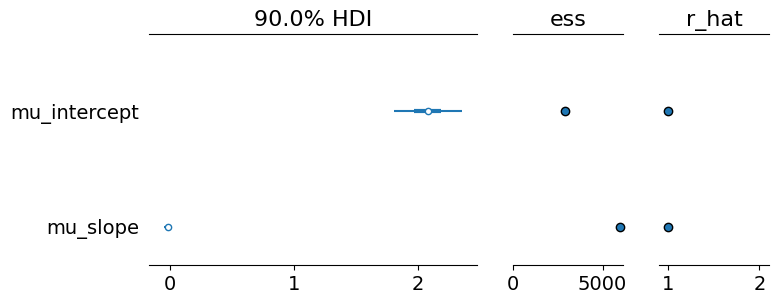

In [5]:

with pm.Model() as hierarchical_model:
    # Hyperpriors for population-level parameters
    mu_intercept = pm.Normal("mu_intercept", mu=0, sigma=2)
    sigma_intercept = pm.HalfNormal("sigma_intercept", sigma=0.5)
    
    mu_slope = pm.Normal("mu_slope", mu=0, sigma=0.1)
    sigma_slope = pm.HalfNormal("sigma_slope", sigma=0.05)
    
    # Non-centered parameterization for varying effects
    alpha_z = pm.Normal("alpha_z", 0, 1, shape=N_AUDIENCES)
    alpha = pm.Deterministic("alpha", mu_intercept + alpha_z * sigma_intercept) #varying intercept
    
    beta_z = pm.Normal("beta_z", 0, 1, shape=N_AUDIENCES)
    beta = pm.Deterministic("beta", mu_slope + beta_z * sigma_slope) #varying slope for clicks
    
    # Linear predictor
    eta = alpha[audience_ids] + beta[audience_ids]*cost
    mu = pm.math.exp(eta)
    
    # Likelihood (observed clicks)
    y = pm.Poisson("y", mu=mu, observed=clicks)
    
    # Sampling
    trace = pm.sample(2000, tune=2000, target_accept=0.95)

# Check hyperparameter recovery
az.plot_forest(trace, var_names=["mu_intercept", "mu_slope"], 
               combined=True, hdi_prob=0.9,
               figsize=(8, 3), 
               r_hat=True, ess=True)
plt.show()

In [13]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Set seed
np.random.seed(42)

# Simulation parameters
N_AUDIENCES = 10  # Number of unique audience members
OBS_PER_AUDIENCE = 10  # Observations per audience member

# True hyperparameters
hyper_mu_intercept = 2.0    # Population-level intercept
hyper_sigma_intercept = 0.5 # Between-audience intercept variability
hyper_mu_slope = -0.03      # Population-level cost slope 
hyper_sigma_slope = 0.01    # Between-audience slope variability

# Simulate audience-specific parameters
audience_ids = np.repeat(np.arange(N_AUDIENCES), OBS_PER_AUDIENCE)
true_intercepts = np.random.normal(hyper_mu_intercept, hyper_sigma_intercept, N_AUDIENCES)
true_slopes = np.random.normal(hyper_mu_slope, hyper_sigma_slope, N_AUDIENCES)

# Simulate cost and clicks
cost = np.random.gamma(shape=5, scale=1, size=N_AUDIENCES*OBS_PER_AUDIENCE)
eta = true_intercepts[audience_ids] + true_slopes[audience_ids] * cost
clicks = np.random.poisson(lam=np.exp(eta))

# Create DataFrame
data = pd.DataFrame({
    "audience_id": audience_ids,
    "cost": cost,
    "clicks": clicks
})

# Visualize relationships for 6 random audiences
sample_audiences = np.random.choice(N_AUDIENCES, 6, replace=False)

with pm.Model() as abc_model:
    # Hyperpriors for population-level parameters
    mu_intercept = pm.Normal("mu_intercept", mu=0, sigma=2)
    sigma_intercept = pm.HalfNormal("sigma_intercept", sigma=0.5)
    
    mu_slope = pm.Normal("mu_slope", mu=0, sigma=0.1)
    sigma_slope = pm.HalfNormal("sigma_slope", sigma=0.05)
    
    alpha_z = pm.Normal("alpha_z", 0, 1, shape=N_AUDIENCES)
    alpha = pm.Deterministic("alpha", mu_intercept + alpha_z * sigma_intercept) #varying intercept
    
    beta_z = pm.Normal("beta_z", 0, 1, shape=N_AUDIENCES)
    beta = pm.Deterministic("beta", mu_slope + beta_z * sigma_slope) #varying slope for clicks
    
    def simulator_model(rng, alpha, beta, size = None):
        audience_ids = data.audience_id
        cost = data.cost

        eta = alpha[audience_ids] + beta[audience_ids]*cost
        clicks = np.random.poisson(lam=np.exp(eta).astype(np.float64))
        return clicks

    pm.Simulator(
        "Y_obs",
        simulator_model,
        params = (alpha, beta),
        distance = "gaussian",
        sum_stat = "sort",
        epsilon = 10,
        observed = clicks,
    )

with abc_model:
    trace = pm.sample_smc(
        draws = 1000, 
        chains = 2,
        cores = 1,
        compute_convergence_checks = True,
        return_inferencedata = True,
        progressbar = True
    )

    textsize = 7
    for plot in ["trace"]:
        az.plot_trace(trace, kind = plot, plot_kwargs = {"textsize": textsize})
        plt.show()

    df = trace.to_dataframe(include_coords=False, groups="posterior")
    print(df.head(25))

Initializing SMC sampler...
Sampling 1 chain in 1 job


Output()

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.